In [182]:
import pandas as panda
import numpy as np
from geopy.geocoders import Nominatim
from collections import defaultdict
from geopy.exc import GeocoderTimedOut
import time
from matplotlib import pyplot as plot
import seaborn as sns
from wordcloud import WordCloud
import ast
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
culture_center_data_path = 'MSFC_44 Wards_Complete_Final.xlsx'
culture_data = panda.read_excel(culture_center_data_path)
culture_data.shape

(1397, 16)

In [3]:
culture_data.head()

FACILITY NAME  \
0                                     Thistletown CC   
1                          Albion Pool & Health Club   
2                                Albion Branch (TPL)   
3  Theatre Francais de Toronto - Centre for Creation   
4                           Humber Arboretum Gardens   

                                        Full Address Street #  \
0              925 Albion Road, Toronto, ON, M9V 1A6      925   
1             1485 Albion Road, Toronto, ON, M9V 1B2     1485   
2             1515 Albion Road, Toronto, ON, M9V 1B2     1515   
3  21 College Street, Office 610, Toronto, ON, M5...       21   
4  203 Humber College Boulevard, Toronto, ON, M9W...      203   

                Street Name       Suite     City Province Postal Code  Ward  \
0               Albion Road         NaN  Toronto       ON     M9V 1A6     1   
1               Albion Road         NaN  Toronto       ON     M9V 1B2     1   
2               Albion Road         NaN  Toronto       ON     M9V 1B2     1   
3            College Street  Office 610  Toronto       ON     M5G 2B3     1   
4  Humber College Boulevard         NaN  Toronto       ON     M9W 5L7     1   

   Performance  Exhibition / Visual Arts  Screen Based  Library  Multipurpose  \
0          1.0                       NaN           NaN      NaN           1.0   
1          NaN                       NaN           NaN      NaN           1.0   
2          1.0                       NaN           NaN      1.0           1.0   
3          1.0                       NaN           NaN      NaN           NaN   
4          NaN                       NaN           NaN      NaN           1.0   

   Heritage        OWNERSHIP  
0       NaN    City Operated  
1       NaN       City Owned  
2       NaN    City Operated  
3       1.0  Owned by others  
4       NaN       City Owned

#### Observations so far about the data given:

1. Total of 1397 culture centers data is provided with 16 different fields of data


2. There are no numeric values denoting either count /seating capacity / revenue etc for the centers


3. Obvious categorical value are Performance, Exhibition/Visual Arts, Screen based, Library, Multipurpose,Heritage and Ownership


4. Data cleaning is required for the categorical fields


5. Column street address is an amalgamation of columns street #, street name , province ,city and postal code



#### Next Steps :


1. Rename the columns to useful feature names


2. Check for null values across columns


3. Check if any community center detail has been duplicated


4. Correct NaN values for categorical fields


5. Change categorical field types to integer


6. Get geo latitude and longitude coordinates for each center


In [4]:
culture_data.columns = ['facility',\
                        'full_adress',\
                        'street',\
                        'street_name',\
                        'suite',\
                        'city',\
                        'province',\
                        'postal_code',\
                        'ward',\
                        'performance', \
                        'exhibition', \
                        'screen_based', \
                        'library', \
                        'multi_purpose', \
                        'heritage', \
                        'ownership'
                       ]

In [5]:
culture_data.isnull().any()

facility         False
full_adress      False
street           False
street_name      False
suite             True
city             False
province         False
postal_code      False
ward             False
performance       True
exhibition        True
screen_based      True
library           True
multi_purpose     True
heritage          True
ownership        False
dtype: bool

Suite: according to our data dictionary- Suite or room number of facility if part of a larger facility. 

Values are usually details like which particular wing/floor/unit. Seeing that this specific data is not really useful for the purposes of our analysis we are going to change the value to 1 for part of larger building or 0 as standalone building.

We are going to replace the missing values in this column with a value of 0

In [6]:
culture_data.suite.nunique()

107

In [7]:
culture_data.suite.value_counts().head()

A            9
B            4
2nd Floor    4
Suite 200    3
4th Floor    3
Name: suite, dtype: int64

In [8]:
##replace NaN with 0
culture_data.suite.isnull().sum()

1261

In [9]:
culture_data.suite.fillna(value=0,inplace=True)
culture_data.suite.isnull().sum()

0

In [10]:
culture_data.suite = culture_data.suite.apply(lambda x: 1 if x!=0 else 0)
culture_data.suite.value_counts()

0    1261
1     136
Name: suite, dtype: int64

Lets deal with our next simplest data field ownership. We are going to encode the same using the following rule:

1 for City Owned<br>
2 for City operated <br>
0 for owned by others

In [11]:
culture_data.ownership.value_counts()

Owned by others    1104
City Owned          218
City Operated        54
City operated        16
City owned            4
City owned            1
Name: ownership, dtype: int64

It is clear that there are some duplicate entries for data formatting issues. We will trim and replace all with lowercase

In [12]:
culture_data.ownership= culture_data.ownership.apply(lambda x: x.lower().strip())
culture_data.ownership.value_counts()

owned by others    1104
city owned          223
city operated        70
Name: ownership, dtype: int64

In [13]:
culture_data.ownership = culture_data.ownership.apply(lambda x: 1 if x=='city owned' else (2 if x=='city operated' else 0))
culture_data.ownership.value_counts()

0    1104
1     223
2      70
Name: ownership, dtype: int64

We will deal with our other categorical data which are : Performance based/screen based, etc.<br>
Most of  these values have 1 as True value and NaN as false value<br>
We will replace NaN with 0 and change type of cells to integer

In [14]:
culture_data.performance.fillna(value=0, inplace=True)
culture_data.exhibition.fillna(value=0,inplace =True)
culture_data.screen_based.fillna(value=0,inplace =True)
culture_data.library.fillna(value=0,inplace =True)
culture_data.heritage.fillna(value=0,inplace =True)
culture_data.multi_purpose.fillna(value=0,inplace =True)
culture_data[['performance','exhibition','screen_based','library','heritage','multi_purpose']].isnull().sum()

performance      0
exhibition       0
screen_based     0
library          0
heritage         0
multi_purpose    0
dtype: int64

In [15]:
culture_data.performance=culture_data.performance.astype(np.int64)
culture_data.exhibition=culture_data.exhibition.astype(np.int64)
culture_data.screen_based=culture_data.screen_based.astype(np.int64)
culture_data.library=culture_data.library.astype(np.int64)
culture_data.multi_purpose=culture_data.multi_purpose.astype(np.int64)
culture_data.heritage=culture_data.heritage.astype(np.int64)


culture_data.dtypes

facility         object
full_adress      object
street           object
street_name      object
suite             int64
city             object
province         object
postal_code      object
ward              int64
performance       int64
exhibition        int64
screen_based      int64
library           int64
multi_purpose     int64
heritage          int64
ownership         int64
dtype: object

In [16]:
culture_data[['performance','exhibition','screen_based','library','heritage','multi_purpose']].nunique()

performance      2
exhibition       2
screen_based     2
library          2
heritage         2
multi_purpose    2
dtype: int64

Check for duplicate community center names

In [17]:
culture_data.shape, culture_data.facility.nunique()

((1397, 16), 1394)

In [18]:
t = culture_data.groupby(['facility'])['street'].count().reset_index()

In [19]:
t[t.street>1]

facility  street
523          Guildwood Branch (TPL)       2
666  Lawrence Park Community Church       2
668  Learning Enrichment Foundation       2

In [20]:
bad_facilities = t[t.street>1].facility.values.tolist()

We found the offending duplicate facility names, lets look at them in further detail

In [21]:
culture_data[culture_data.facility.isin(bad_facilities)].sort_values(by='facility')

facility  \
782           Guildwood Branch (TPL)   
1374          Guildwood Branch (TPL)   
810   Lawrence Park Community Church   
829   Lawrence Park Community Church   
141   Learning Enrichment Foundation   
157   Learning Enrichment Foundation   

                                      full_adress street        street_name  \
782   123 Guildwood Parkway, Toronto, ON, M1E 4V2    123  Guildwood Parkway   
1374  123 Guildwood Parkway, Toronto, ON, M1E 5G5    123  Guildwood Parkway   
810     2180 Bayview Avenue, Toronto, ON, M4N 3K7   2180     Bayview Avenue   
829     2180 Bayview Avenue, Toronto, ON, M4N 3K7   2180     Bayview Avenue   
141        1267 Weston Road, Toronto, ON, M6M 4P9   1267        Weston Road   
157        116 Industry St., Toronto, ON, M6M 4L8    116       Industry St.   

      suite     city province postal_code  ward  performance  exhibition  \
782       0  Toronto       ON     M1E 4V2    23            0           0   
1374      0  Toronto       ON     M1E 5G5    43            0           0   
810       0  Toronto       ON     M4N 3K7    25            1           0   
829       0  Toronto       ON     M4N 3K7    25            1           0   
141       0  Toronto       ON     M6M 4P9    11            0           0   
157       0  Toronto       ON     M6M 4L8    12            0           0   

      screen_based  library  multi_purpose  heritage  ownership  
782              0        1              0         0          2  
1374             0        1              0         0          2  
810              0        0              0         0          0  
829              0        0              1         0          0  
141              0        0              1         0          0  
157              0        0              1         0          0

We found 3 venues which are repeated and this is how we are going to deal with the same:
    
    1. Guildwood branch public library is present at M1E 4V2. Hence the second location is incorrect, we will drop the row at index 1374
    2. Learning Enrichment Foundation and Lawrence Park Community Church are present in different locations. We will retain them as is
    

In [22]:
culture_data.drop(1374, inplace=True)

In [23]:
culture_data.shape

(1396, 16)

At this point , we have a cleaned dataset. We will proceed to add further details in order to analyze/visualize the data further

In [24]:
culture_data.street = culture_data.street.astype(np.object)

In [25]:
culture_data[['street', 'street_name', 'city']].dtypes

street         object
street_name    object
city           object
dtype: object

In [26]:
culture_data['address_for_geo_search']=culture_data.street.map(str) + ' '+ culture_data.street_name+' '+culture_data.city

In [27]:
culture_data.address_for_geo_search.head()

0                 925 Albion Road Toronto
1                1485 Albion Road Toronto
2                1515 Albion Road Toronto
3               21 College Street Toronto
4    203 Humber College Boulevard Toronto
Name: address_for_geo_search, dtype: object

In [28]:
culture_data.address_for_geo_search.isnull().sum()

0

### Visualization of Data

#### Distribution of culture /community centers across wards

In [29]:
culture_data.ownership.value_counts()

0    1104
1     223
2      69
Name: ownership, dtype: int64

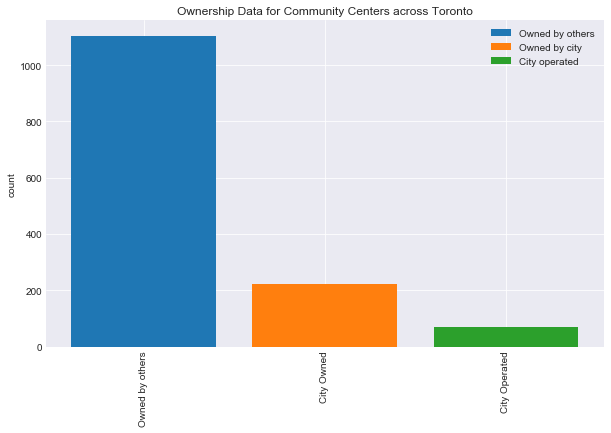

In [30]:
plot.style.use("seaborn-darkgrid")
plot.figure(figsize = (10,6))
# culture_data.ownership.value_counts().plot(kind='bar')
plot.bar(0, culture_data.ownership.value_counts()[0], label='Owned by others')
plot.bar(1, culture_data.ownership.value_counts()[1], label='Owned by city')
plot.bar(2, culture_data.ownership.value_counts()[2], label='City operated')
plot.title('Ownership Data for Community Centers across Toronto')
plot.legend(loc='best')
plot.ylabel('count')
plot.xticks(np.arange(3),('Owned by others','City Owned','City Operated'), rotation=90)
plot.show()

In [31]:
culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum()

performance      748
exhibition       494
screen_based     113
library           98
multi_purpose    659
heritage         217
dtype: int64

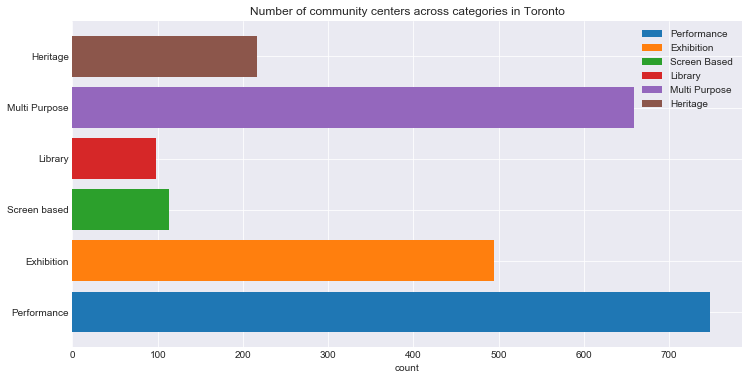

In [32]:
plot.style.use("seaborn-darkgrid")
plot.figure(figsize=(12,6))
plot.barh(0,culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum()[0],label='Performance')
plot.barh(1,culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum()[1],label='Exhibition')
plot.barh(2,culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum()[2],label='Screen Based')
plot.barh(3,culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum()[3],label='Library')
plot.barh(4,culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum()[4],label='Multi Purpose')
plot.barh(5,culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum()[5],label='Heritage')

plot.title('Number of community centers across categories in Toronto')
plot.xlabel('count')
plot.yticks(np.arange(6),('Performance','Exhibition','Screen based','Library','Multi Purpose','Heritage'))
plot.legend(loc='best')
plot.show()



In [33]:
culture_data.ward.nunique()

44

Lets visualize distribution of community center ownerships with respect to specific wards.
THere are a total of 44 wards, we are going to plot the various distribution across subplots of 15 * 3

In [34]:
temp = culture_data.groupby(['ward'])[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum().reset_index()
temp.head()

ward  performance  exhibition  screen_based  library  multi_purpose  \
0     1            6           1             0        1             11   
1     2            7           1             0        3             10   
2     3            5           4             1        1             10   
3     4            5           2             0        1              6   
4     5           14           3             2        3             16   

   heritage  
0         2  
1         0  
2         2  
3         1  
4         1

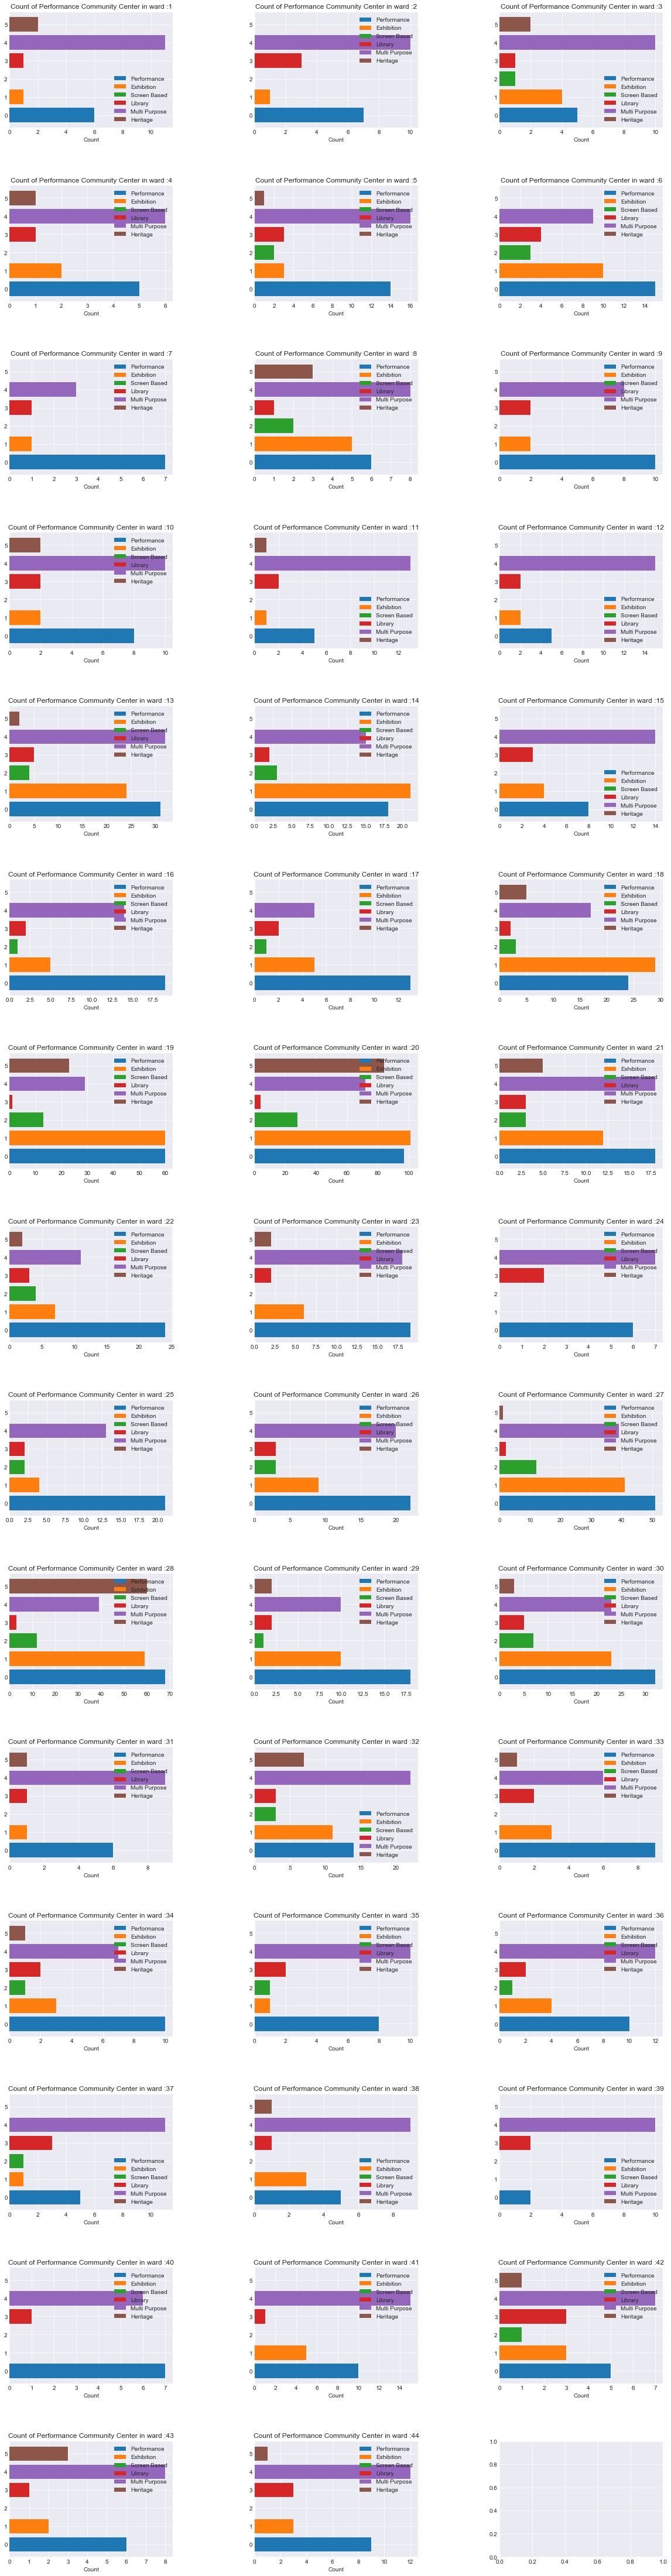

In [35]:
def plot_category_of_centers_across_wards(table):
    plot.style.use("seaborn-darkgrid")
    fig, ax = plot.subplots(15,3, figsize=(20,80))
    plot.subplots_adjust(wspace=0.5,hspace=0.5)
    count = 0
    for cardinal, axes in enumerate(ax):

        for col_axes in axes:
            if count < 44:
                
                col_axes.barh(0, table.iloc[count]['performance'], label='Performance')
                col_axes.barh(1, table.iloc[count]['exhibition'], label='Exhibition')
                col_axes.barh(2, table.iloc[count]['screen_based'], label='Screen Based')
                col_axes.barh(3, table.iloc[count]['library'], label='Library')
                col_axes.barh(4, table.iloc[count]['multi_purpose'], label='Multi Purpose')
                col_axes.barh(5, table.iloc[count]['heritage'], label='Heritage')
                col_axes.set_title('Count of Performance Community Center in ward :'+ str(table.iloc[count]['ward']))
                col_axes.set_yticks(np.arange(6),\
                                    ('Performance','Exhibition','Screen based','Library','Multi Purpose','Heritage'),\
                                  )
                col_axes.set_xlabel('Count')
                col_axes.legend(loc='best')
                count+= 1
    plot.show()

plot_category_of_centers_across_wards(temp)

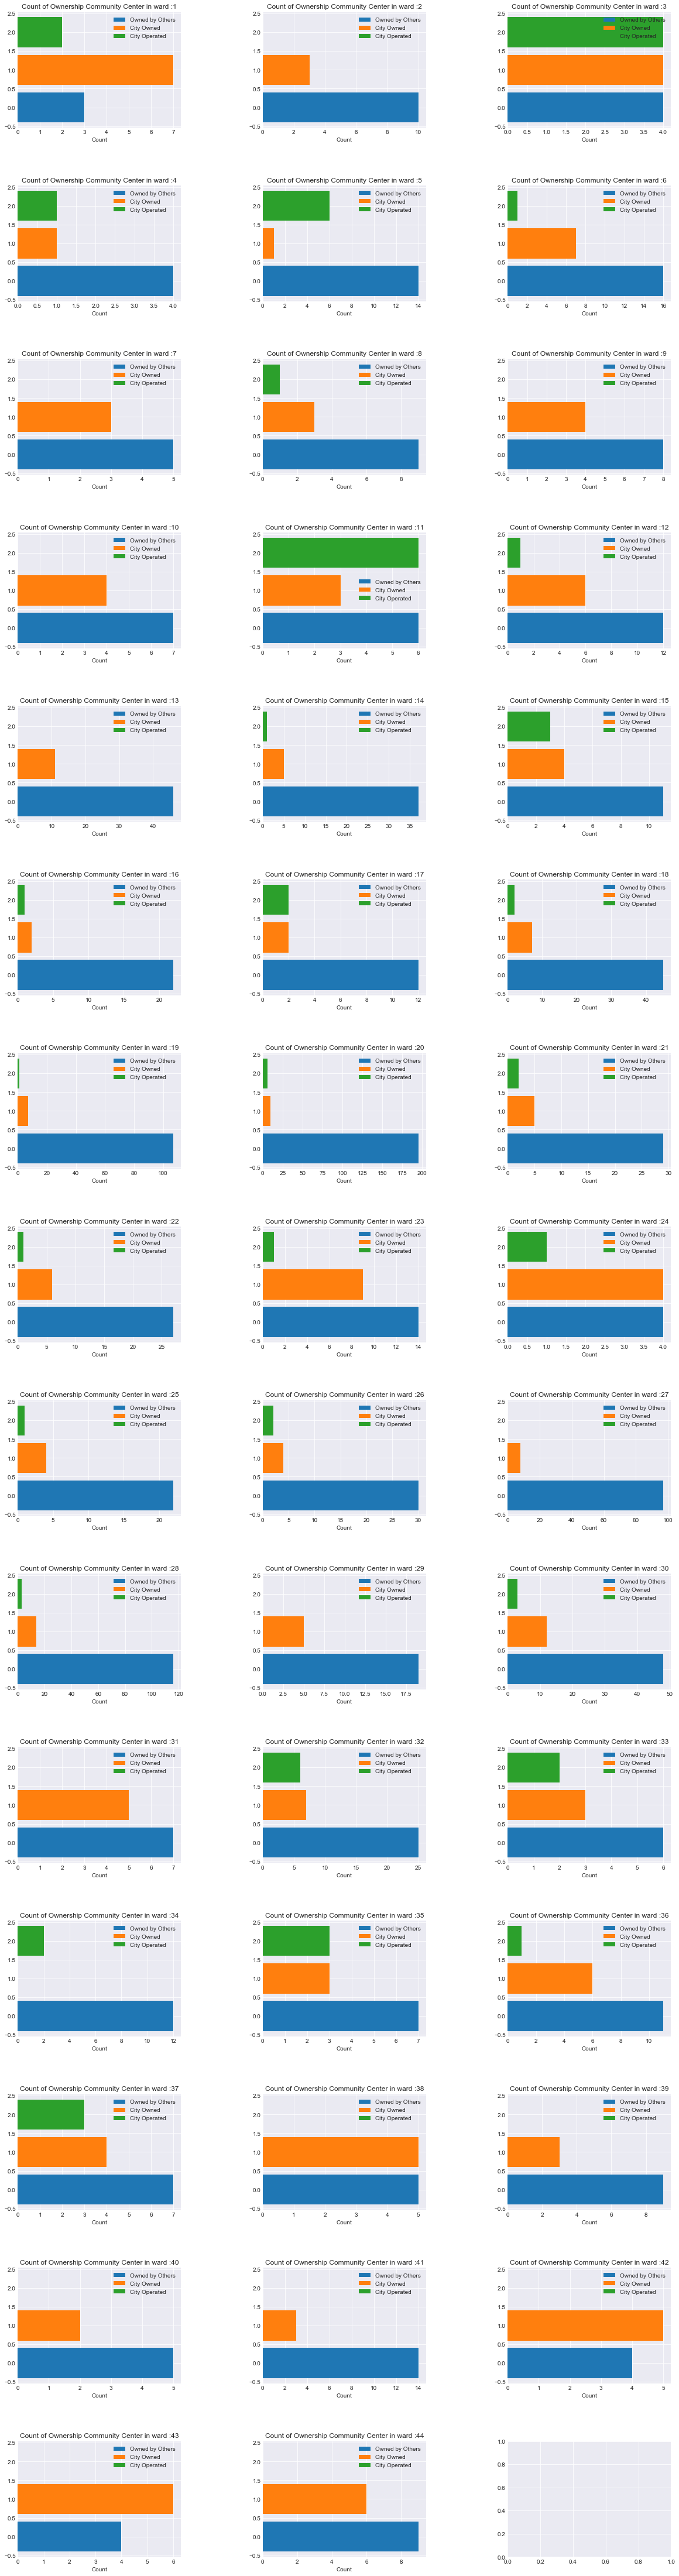

In [36]:
def plot_ownership_across_wards(table):
    plot.style.use("seaborn-darkgrid")
    fig, ax = plot.subplots(15,3, figsize=(20,80))
    plot.subplots_adjust(wspace=0.5,hspace=0.5)
    count = 0
    for cardinal, axes in enumerate(ax):

        for col_axes in axes:
            if count < 44:
                
                col_axes.barh(0, table.iloc[count]['0'], label='Owned by Others')
                col_axes.barh(1, table.iloc[count]['1'], label='City Owned')
                col_axes.barh(2, table.iloc[count]['2'], label='City Operated')
                col_axes.set_title('Count of Ownership Community Center in ward :'+ str(table.iloc[count]['ward']))
                col_axes.set_yticks(np.arange(3),('Owned by Others','City Owned','City Operated'))
                col_axes.set_xlabel('Count')
                col_axes.legend(loc='best')
                count+= 1
    plot.show()

t = culture_data.groupby(['ward','ownership']).size().unstack(fill_value=0).reset_index()
t.columns = ['ward','0','1','2']

plot_ownership_across_wards(t)

In [37]:
#which ward has highest number of city owned/city operated/owned by others of community center
ward_with_highest_owned_by_others = t[['ward','0']].sort_values(by='0', ascending=False).head(1)
ward_with_highest_city_owned = t[['ward','1']].sort_values(by='1', ascending=False).head(1)
ward_with_highest_city_operated= t[['ward','2']].sort_values(by='2', ascending=False).head(1)

highest_ward_diff_ownership = {}
for category in ['0','1','2']:
    
    response = t[['ward',category]].sort_values(by=category, ascending=False).head(1)
    highest_ward_diff_ownership[category]= [response.ward.values[0],response[category].values[0]]

highest_ward_diff_ownership

{'0': [20, 195], '1': [28, 14], '2': [11, 6]}

In [38]:
highest_ward_diff_ownership = panda.DataFrame(highest_ward_diff_ownership).T.reset_index()
highest_ward_diff_ownership.columns=['ownership','ward number','count']
highest_ward_diff_ownership.ownership = highest_ward_diff_ownership.ownership.apply(lambda x:\
                                                     'Owned By Others' if x == str(0) else\
                                                    ('City Owned' if x ==str(1) else 'City Operated')
                                                                                   )
highest_ward_diff_ownership

ownership  ward number  count
0  Owned By Others           20    195
1       City Owned           28     14
2    City Operated           11      6

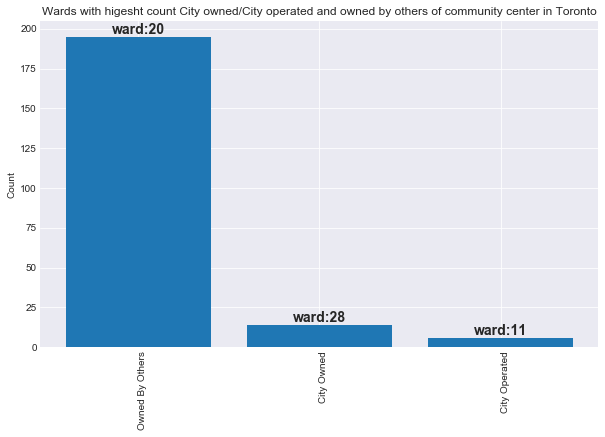

In [39]:
plot.style.use('seaborn-darkgrid')
fig, ax = plot.subplots(figsize=(10,6))
bar = ax.bar(np.arange(len(highest_ward_diff_ownership)), height = highest_ward_diff_ownership['count'].values.tolist())
ax.set_xticks(np.arange(len(highest_ward_diff_ownership)))
ax.set_xticklabels(highest_ward_diff_ownership['ownership'].values.tolist(), ha='left',rotation=90)
count = 0
for rect in bar:
    height = rect.get_height()
    text = highest_ward_diff_ownership.iloc[count]['ward number']
    plot.text(rect.get_x() + rect.get_width()/2., 1*height,
            'ward:%s'%text ,
            ha='center', va='bottom', fontsize=14,weight='bold')
    count+= 1
ax.set_title('Wards with higesht count City owned/City operated and owned by others of community center in Toronto')
ax.set_ylabel('Count')
plot.show()

In [42]:
highest_ward_diff_categories = {}
for category in ['performance','exhibition','screen_based','library','multi_purpose','heritage']:
    
    response = temp[['ward',category]].sort_values(by=category, ascending=False).head(1)
    highest_ward_diff_categories[category]= [response.ward.values[0],response[category].values[0]]
#     print(response.ward.values[0])
highest_ward_diff_categories

{'performance': [20, 97],
 'exhibition': [20, 101],
 'screen_based': [20, 28],
 'library': [13, 5],
 'multi_purpose': [20, 72],
 'heritage': [20, 84]}

In [43]:
highest_ward_diff_categories = panda.DataFrame(highest_ward_diff_categories).T.reset_index()
highest_ward_diff_categories.columns=['category','ward number','count']
highest_ward_diff_categories

category  ward number  count
0    performance           20     97
1     exhibition           20    101
2   screen_based           20     28
3        library           13      5
4  multi_purpose           20     72
5       heritage           20     84

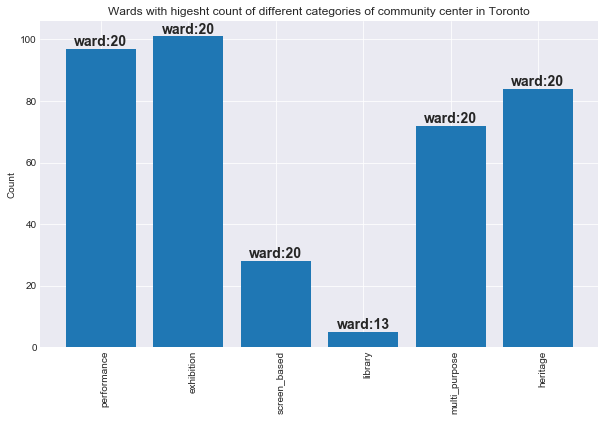

In [44]:
plot.style.use('seaborn-darkgrid')
fig, ax = plot.subplots(figsize=(10,6))
bar = ax.bar(np.arange(len(highest_ward_diff_categories)), height = highest_ward_diff_categories['count'].values.tolist())
ax.set_xticks(np.arange(len(highest_ward_diff_categories)))
ax.set_xticklabels(highest_ward_diff_categories['category'].values.tolist(), ha='left',rotation=90)
count = 0
for rect in bar:
    height = rect.get_height()
    text = highest_ward_diff_categories.iloc[count]['ward number']
    plot.text(rect.get_x() + rect.get_width()/2., 1*height,
            'ward:%s'%text ,
            ha='center', va='bottom', fontsize=14,weight='bold')
    count+= 1
ax.set_title('Wards with higesht count of different categories of community center in Toronto')
ax.set_ylabel('Count')
plot.show()

In [ ]:
culture_data[['performance','exhibition','screen_based','library','multi_purpose','heritage']].sum().sum(), culture_data.shape[0]

It is clear that total number of community centers in Toronto are 1396.
Out of which many serve multi purposes

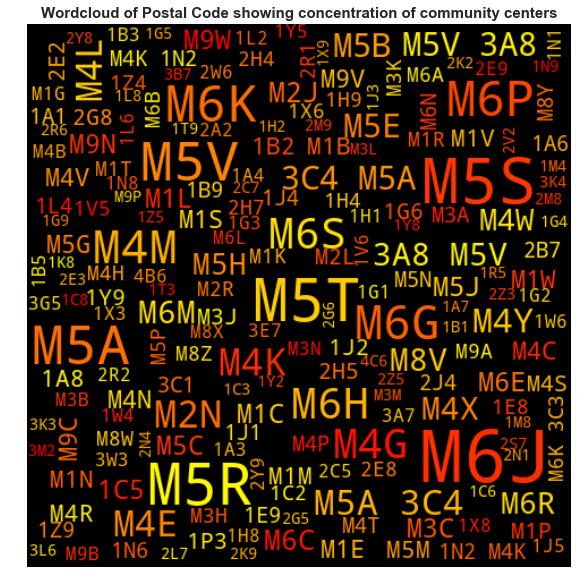

In [87]:
## Lets find out which street has the highest concentration of community centers using a wordcloud

diff_street_names = culture_data.postal_code.values.tolist()

wordcloud = WordCloud(width=480, height=480, max_font_size=65, min_font_size=10, background_color="black",colormap="autumn").generate(' '.join(diff_street_names))
plot.figure(figsize = (10,10))
plot.imshow(wordcloud, interpolation="bilinear")
plot.axis("off")
plot.title('Wordcloud of Postal Code showing concentration of community centers', fontsize=15, weight='bold')
plot.show()


In [88]:
ordinate = panda.read_csv('ordinate.csv')
ordinate_1 = panda.read_csv('ordinate_1.csv')

In [89]:
ordinate.shape, ordinate_1.shape

((539, 2), (1087, 2))

In [90]:
ordinates = panda.concat([ordinate,ordinate_1])
ordinates.shape

(1626, 2)

In [94]:
ordinates.ordinate= ordinates.ordinate.apply(lambda x: ast.literal_eval(x))
ordinates.head()

location                         ordinate
0               925 Albion Road Toronto  [43.7354505, -79.5625273607685]
1              1485 Albion Road Toronto         [43.7396133, -79.580608]
2              1515 Albion Road Toronto  [43.7398714, -79.5848098635851]
3             21 College Street Toronto        [43.7343246, -79.5629976]
4  203 Humber College Boulevard Toronto        [43.7298449, -79.6037919]

In [97]:
ordinates['latitude'] = ordinates.ordinate.apply(lambda x: x[0])
ordinates['longitude'] = ordinates.ordinate.apply(lambda x: x[1])

In [100]:
ordinates.drop(columns = ['ordinate'], inplace=True)
ordinates.head()

location   latitude  longitude
0               925 Albion Road Toronto  43.735450 -79.562527
1              1485 Albion Road Toronto  43.739613 -79.580608
2              1515 Albion Road Toronto  43.739871 -79.584810
3             21 College Street Toronto  43.734325 -79.562998
4  203 Humber College Boulevard Toronto  43.729845 -79.603792

In [102]:
ordinates.rename(columns = {'location':'address_for_geo_search'}, inplace = True)
ordinates.head(1)

address_for_geo_search  latitude  longitude
0  925 Albion Road Toronto  43.73545 -79.562527

In [114]:
ordinates.drop_duplicates(inplace=True,keep='first')

In [115]:
ordinates.shape, culture_data.shape

((1323, 3), (1396, 17))

In [122]:
# tt = panda.merge(culture_data,ordinates, on='address_for_geo_search', how='left')
tt=culture_data.join(ordinates.set_index('address_for_geo_search'), on='address_for_geo_search')
tt.head()

facility  \
0                                     Thistletown CC   
1                          Albion Pool & Health Club   
2                                Albion Branch (TPL)   
3  Theatre Francais de Toronto - Centre for Creation   
4                           Humber Arboretum Gardens   

                                         full_adress street  \
0              925 Albion Road, Toronto, ON, M9V 1A6    925   
1             1485 Albion Road, Toronto, ON, M9V 1B2   1485   
2             1515 Albion Road, Toronto, ON, M9V 1B2   1515   
3  21 College Street, Office 610, Toronto, ON, M5...     21   
4  203 Humber College Boulevard, Toronto, ON, M9W...    203   

                street_name  suite     city province postal_code  ward  \
0               Albion Road      0  Toronto       ON     M9V 1A6     1   
1               Albion Road      0  Toronto       ON     M9V 1B2     1   
2               Albion Road      0  Toronto       ON     M9V 1B2     1   
3            College Street      1  Toronto       ON     M5G 2B3     1   
4  Humber College Boulevard      0  Toronto       ON     M9W 5L7     1   

   performance  exhibition  screen_based  library  multi_purpose  heritage  \
0            1           0             0        0              1         0   
1            0           0             0        0              1         0   
2            1           0             0        1              1         0   
3            1           0             0        0              0         1   
4            0           0             0        0              1         0   

   ownership                address_for_geo_search   latitude  longitude  
0          2               925 Albion Road Toronto  43.735450 -79.562527  
1          1              1485 Albion Road Toronto  43.739613 -79.580608  
2          2              1515 Albion Road Toronto  43.739871 -79.584810  
3          0             21 College Street Toronto  43.734325 -79.562998  
4          1  203 Humber College Boulevard Toronto  43.729845 -79.603792

In [124]:
tt.dropna(inplace=True)
tt.isnull().any().any()

False

In [126]:
culture_data_with_ordinates = tt

In [138]:
toronto_latitude = 43.6532
toronto_longitude = -79.3832

In [144]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough in zip(culture_data_with_ordinates['latitude'], culture_data_with_ordinates['longitude'], culture_data_with_ordinates['address_for_geo_search']):
    label = '{0}, {1}'.format(borough, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=borough,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_newyork)  
    
map_newyork

## Prepare for clustering/segmentation

In [147]:
grpby = culture_data_with_ordinates.groupby(['ward'])

In [150]:
aggregate ={
    
    'performance':['mean','sum','nunique'],
    'exhibition':['mean','sum','nunique'],
    'multi_purpose':['mean','sum','nunique'],
    'screen_based':['mean','sum','nunique'],
    'library':['mean','sum','nunique'],
    'heritage':['mean','sum','nunique'],
    'ownership':['mean','sum','nunique'],
}

In [153]:
cul_agg = grpby.agg(aggregate).reset_index()
cul_agg.head()

ward performance             exhibition             multi_purpose      \
              mean sum nunique       mean sum nunique          mean sum   
0    1    0.500000   6       2   0.083333   1       2      0.916667  11   
1    2    0.538462   7       2   0.076923   1       2      0.769231  10   
2    3    0.416667   5       2   0.333333   4       2      0.833333  10   
3    4    0.833333   5       2   0.333333   2       2      1.000000   6   
4    5    0.666667  14       2   0.142857   3       2      0.761905  16   

            ...   screen_based   library              heritage              \
  nunique   ...        nunique      mean sum nunique      mean sum nunique   
0       2   ...              1  0.083333   1       2  0.166667   2       2   
1       2   ...              1  0.230769   3       2  0.000000   0       1   
2       2   ...              2  0.083333   1       2  0.166667   2       2   
3       1   ...              1  0.166667   1       2  0.166667   1       2   
4       2   ...              2  0.142857   3       2  0.047619   1       2   

  ownership              
       mean sum nunique  
0  0.916667  11       3  
1  0.230769   3       2  
2  1.000000  12       3  
3  0.500000   3       3  
4  0.619048  13       3  

[5 rows x 22 columns]

In [157]:
cul_agg.columns = ['_'.join(i) for i in cul_agg.columns.tolist()]

In [158]:
cul_agg.head()

ward_  performance_mean  performance_sum  performance_nunique  \
0      1          0.500000                6                    2   
1      2          0.538462                7                    2   
2      3          0.416667                5                    2   
3      4          0.833333                5                    2   
4      5          0.666667               14                    2   

   exhibition_mean  exhibition_sum  exhibition_nunique  multi_purpose_mean  \
0         0.083333               1                   2            0.916667   
1         0.076923               1                   2            0.769231   
2         0.333333               4                   2            0.833333   
3         0.333333               2                   2            1.000000   
4         0.142857               3                   2            0.761905   

   multi_purpose_sum  multi_purpose_nunique        ...          \
0                 11                      2        ...           
1                 10                      2        ...           
2                 10                      2        ...           
3                  6                      1        ...           
4                 16                      2        ...           

   screen_based_nunique  library_mean  library_sum  library_nunique  \
0                     1      0.083333            1                2   
1                     1      0.230769            3                2   
2                     2      0.083333            1                2   
3                     1      0.166667            1                2   
4                     2      0.142857            3                2   

   heritage_mean  heritage_sum  heritage_nunique  ownership_mean  \
0       0.166667             2                 2        0.916667   
1       0.000000             0                 1        0.230769   
2       0.166667             2                 2        1.000000   
3       0.166667             1                 2        0.500000   
4       0.047619             1                 2        0.619048   

   ownership_sum  ownership_nunique  
0             11                  3  
1              3                  2  
2             12                  3  
3              3                  3  
4             13                  3  

[5 rows x 22 columns]

In [164]:
cul_agg.columns

Index(['ward_', 'performance_mean', 'performance_sum', 'performance_nunique',
       'exhibition_mean', 'exhibition_sum', 'exhibition_nunique',
       'multi_purpose_mean', 'multi_purpose_sum', 'multi_purpose_nunique',
       'screen_based_mean', 'screen_based_sum', 'screen_based_nunique',
       'library_mean', 'library_sum', 'library_nunique', 'heritage_mean',
       'heritage_sum', 'heritage_nunique', 'ownership_mean', 'ownership_sum',
       'ownership_nunique'],
      dtype='object')

In [165]:
data_for_clustering = StandardScaler().fit_transform(\
cul_agg[[i for i in cul_agg.columns.tolist() if i not in ['ward_']]]\
)

C:\Users\somak\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\somak\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [166]:
## Because all our data is mean,we can simply take the values as is without putting it through scaling/normalization
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_for_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2,
       1, 0, 2, 2, 2, 3, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1])

In [167]:
len(kmeans.labels_), cul_agg.shape

(44, (44, 22))

In [168]:
cul_agg['cluster']=kmeans.labels_

In [169]:
cul_agg.head()

ward_  performance_mean  performance_sum  performance_nunique  \
0      1          0.500000                6                    2   
1      2          0.538462                7                    2   
2      3          0.416667                5                    2   
3      4          0.833333                5                    2   
4      5          0.666667               14                    2   

   exhibition_mean  exhibition_sum  exhibition_nunique  multi_purpose_mean  \
0         0.083333               1                   2            0.916667   
1         0.076923               1                   2            0.769231   
2         0.333333               4                   2            0.833333   
3         0.333333               2                   2            1.000000   
4         0.142857               3                   2            0.761905   

   multi_purpose_sum  multi_purpose_nunique   ...     library_mean  \
0                 11                      2   ...         0.083333   
1                 10                      2   ...         0.230769   
2                 10                      2   ...         0.083333   
3                  6                      1   ...         0.166667   
4                 16                      2   ...         0.142857   

   library_sum  library_nunique  heritage_mean  heritage_sum  \
0            1                2       0.166667             2   
1            3                2       0.000000             0   
2            1                2       0.166667             2   
3            1                2       0.166667             1   
4            3                2       0.047619             1   

   heritage_nunique  ownership_mean  ownership_sum  ownership_nunique  cluster  
0                 2        0.916667             11                  3        1  
1                 1        0.230769              3                  2        1  
2                 2        1.000000             12                  3        1  
3                 2        0.500000              3                  3        1  
4                 2        0.619048             13                  3        2  

[5 rows x 23 columns]

In [170]:
cul_agg.rename(columns={'ward_':'ward'}, inplace = True)

In [179]:
a = panda.merge(cul_agg,culture_data_with_ordinates, on='ward',how='left')


In [180]:
a.dropna(inplace=True)
a.shape

(1391, 41)

In [186]:
map_clusters = folium.Map(location= [43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, borough,cluster in zip(a['latitude'], a['longitude'], a['address_for_geo_search'],a['cluster']):
    label = folium.Popup(' Cluster ' + str(lat))
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        popup = borough,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    )\
    .add_to(map_clusters)
       
map_clusters